# Find the Measured Velocities


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from typing import Tuple
from datetime import datetime
from pathlib import Path


def recursive_root(path: str, find="sumo-uc-2023"):
    if os.path.split(path)[-1] == find:
        return Path(path)
    return recursive_root(os.path.split(path)[0], find=find)


ROOT = recursive_root(os.path.abspath("."))
sys.path.append(str(ROOT))


## Read the Configuration


In [3]:
from src.walk_configs import walk_configs


In [4]:
experiment_path = Path(
    "/home/max/tmp/sumo-uc-2023/CarFollowingDefaults/02.06.2023_17.39.54"
)


In [5]:
configs = list(walk_configs(experiment_path))


### Read the File


In [6]:
import pandas as pd


def load_fcd(config):
    fcd_df = pd.read_parquet(config.Blocks.XMLConvertConfig.target)
    fcd_df[["x", "y", "time", "speed"]] = fcd_df[["x", "y", "time", "speed"]].astype(
        float
    )
    return fcd_df


### Filter the Boxes

In [7]:
from shapely.geometry import Polygon, Point
from sumolib.shapes import polygon

polys = polygon.read("/home/max/Development/sumo-uc-2023/sumo-xml/detectors/radar_boxes.xml")

polygon_dict = {
    poly.id: Polygon(poly.shape)
    for poly in polys
    if poly.id in ["Radar137_East_thru", "Radar136_West_thru"]
}

In [8]:
def label_polygons(fcd_df):
    fcd_df['box'] = ''
    for poly_id, poly in polygon_dict.items():
        fcd_df.loc[fcd_df['box'] == '', 'box'] = fcd_df.loc[fcd_df['box'] == '', ['x', 'y']].apply(lambda x: poly.contains(Point(*x)), axis=1, raw=True).map({True: poly_id, False: ''})
    return fcd_df

### Parse the FCD file and Pull out the Acceleration Data


In [12]:
from src.pwlfer import process_trajectories, classify
from tqdm import tqdm

for config in configs:
    if all((Path(config.Metadata.cwd) / f"{poly_id}_summary_df.parquet").exists() for poly_id in polygon_dict.keys()):
        # print(f"skipping: {config.Metadata.cwd}")
        continue
    
    fcd_df = load_fcd(config)
    fcd_df = label_polygons(fcd_df)
    # drop all rows without a box
    fcd_df = fcd_df[fcd_df['box'] != ''].copy()
    
    for box_group in fcd_df.groupby('box'):
        box = box_group[0]
        box_df = box_group[1]
        res = process_trajectories(box_df, time_col="time", speed_col="speed", n_jobs=-1)
        summary_df = pd.DataFrame([{**v, **l} for v in res for l in v.pop("line_fits")])
        summary_df["type"] = summary_df.apply(classify, axis=1)
        summary_df["minimum_time"] = summary_df["end"] - summary_df["start"]
        # save summary_df
        summary_df.to_parquet(Path(config.Metadata.cwd) / f"{box}_summary_df.parquet")

In [39]:
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

# mapbox_key = "pk.eyJ1IjoibWF4LXNjaHJhZGVyIiwiYSI6ImNrOHQxZ2s3bDAwdXQzbG81NjZpZm96bDEifQ.etUi4OK4ozzaP_P8foZn_A"
# fig = go.Figure()

# import sumolib

# net = sumolib.net.readNet(
#     "/home/max/Development/sumo-uc-2023/sumo-xml/net/simplified_reworked.net.xml"
# )


# fcd_df[["lon", "lat"]] = fcd_df[["x", "y"]].apply(
#     lambda x: net.convertXY2LonLat(*x), raw=True, axis=1
# )

# _s = fcd_df.sample(1000)

# # _s.loc[_s['Box'] == 'Radar137_East_thru'] 
# fig.add_trace(
#     go.Scattermapbox(
#         lon=_s.loc[_s['box'] == 'Radar137_East_thru']["lon"],
#         lat=_s.loc[_s['box'] == 'Radar137_East_thru']["lat"],
#         mode="markers",
#         opacity=1,
#         line_width=4,
#         marker=dict(size=4, color="red"),
#     )
# )


# fig.add_trace(
#     go.Scattermapbox(
#         lon=_s.loc[_s['box'] == 'Radar136_West_thru']["lon"],
#         lat=_s.loc[_s['box'] == 'Radar136_West_thru']["lat"],
#         mode="markers",
#         opacity=1,
#         line_width=4,
#         marker=dict(size=4, color="blue"),
#     )
# )

# fig.add_trace(
#     go.Scattermapbox(
#         lon=_s.loc[_s['box'] == '']["lon"],
#         lat=_s.loc[_s['box'] == '']["lat"],
#         mode="markers",
#         opacity=1,
#         line_width=4,
#         marker=dict(size=4, color="green"),
#     )
# )

# fig.update_layout(template="ggplot2", height=600, width=1200, font_size=18)

# fig.update_layout(
#     margin=go.layout.Margin(
#         l=50,  # left margin
#         r=50,  # right margin
#         b=50,  # bottom margin
#         t=50,  # top margin
#     ),
#     mapbox=dict(
#         accesstoken=mapbox_key,
#         bearing=0,
#         style="mapbox://styles/max-schrader/ck8t1cmmc02wk1it9rv28iyte",
#         center=go.layout.mapbox.Center(lat=_s["lat"].mean(), lon=_s["lon"].mean()),
#         pitch=0,
#         zoom=14.1,
#     ),
# )


# fig.show()


In [21]:
summary_df = pd.concat([pd.read_parquet(Path(config.Metadata.cwd) / "summary_df.parquet") for config in configs])
summary_df["type"] = summary_df.apply(classify, axis=1)
summary_df["minimum_time"] = summary_df["end"] - summary_df["start"]


### Individual Vehicles


In [34]:
import pandas as pd
from pathlib import Path

p = Path("/Users/max/Development/tmp/CarFollowingSamples/02.06.2023_07.33.49/29")  # Krauss: 17

summary_df = pd.read_parquet(p / "summary_df.parquet")

accelerate_vehicle = summary_df[
    (summary_df["type"] == "accel")
    & (summary_df["minimum_time"] >= 1)
    & (summary_df["r2"] >= 0.9)
    & (summary_df["slope"] > 1)
]
vehicle_ids = accelerate_vehicle["vehicle_id"].unique()

fcd_df = pd.read_parquet(p / "fcd.parquet")
fcd_df[["x", "y", "time", "speed"]] = fcd_df[["x", "y", "time", "speed"]].astype(
        float
    )



In [50]:
import os
import plotly.express as px
import random

vehicle_id = random.choice(vehicle_ids)
# get the line fits
vehicle_df = summary_df[summary_df["vehicle_id"] == vehicle_id]

# get the vehicle data
vehicle_data = fcd_df[fcd_df["id"] == vehicle_id].copy()

vehicle_data["time"] = vehicle_data["time"] - vehicle_data["time"].min()

# create the figure
fig = px.line(vehicle_data, x="time", y="speed")

line_fits = vehicle_df.to_dict(orient="records")

# loop through the line fits
for line_fit in line_fits:
    # get the break
    break_ = line_fit["break"]
    # get the slope
    slope = line_fit["slope"]
    # get the r2
    r2 = line_fit["r2"]
    # get the type
    type_ = line_fit["type"]
    # get the mean speed
    y0 = line_fit["y0"]

    # get the min and max time
    min_time = line_fit["start"]
    max_time = line_fit["end"]
    # add the line
    fig.add_scatter(
        x=[min_time, max_time],
        y=[slope * (min_time) + y0, slope * (max_time) + y0],
        mode="lines",
    )
    # add text of the slope to the middle of the line
    fig.add_annotation(
        x=min_time,
        y=(slope * (min_time) + y0) + 2,
        text=f"accel: {slope:.2f} m/s^2<br>r^2: {r2:.2f}<br>type: {type_}<br>speed: {line_fit['speed']:.2f} mps",
        showarrow=False,
        font=dict(size=14),
    )

    # add the title
    # fig.update_layout(title=f"Vehicle ID: {vehicle_id}<br>Mean Time: {mean_time}")

fig.show()


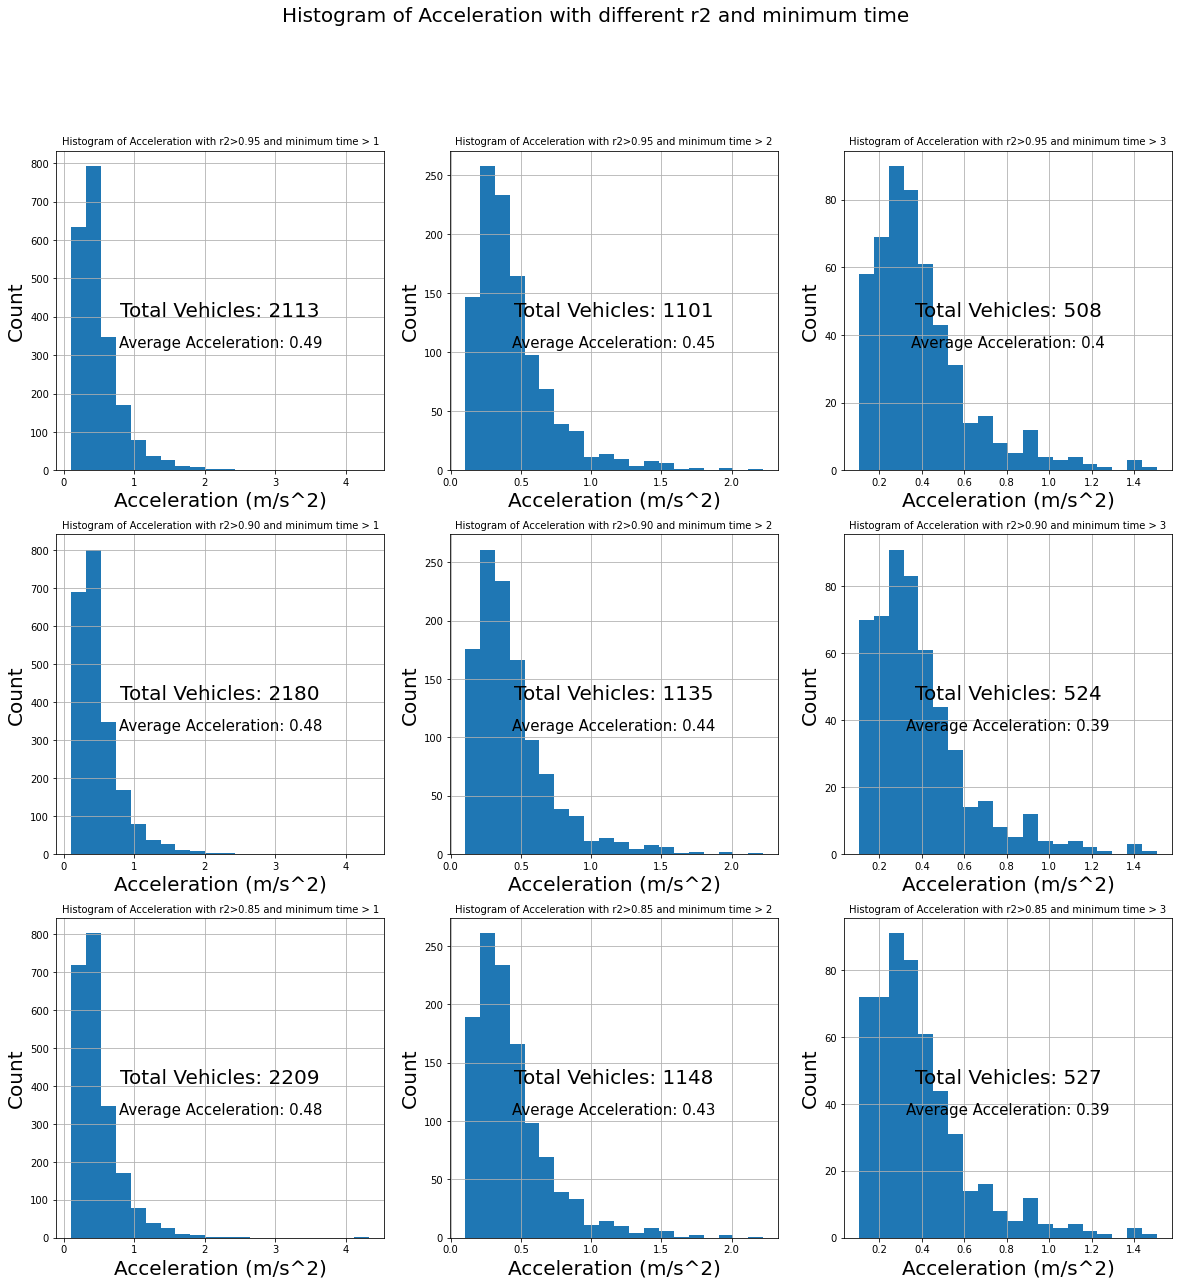

In [24]:
import matplotlib.pyplot as plt

# make histogram of acceleration 3*3 histogram of acceleration with different r2 and minimum time
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
fig.suptitle(
    "Histogram of Acceleration with different r2 and minimum time", fontsize=20
)
# r2>0.95 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.95)
    & (summary_df["minimum_time"] > 1),
    "slope",
].hist(bins=20, ax=axs[0, 0])
axs[0, 0].set_title(
    "Histogram of Acceleration with r2>0.95 and minimum time > 1", fontsize=10
)
axs[0, 0].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[0, 0].set_ylabel("Count", fontsize=20)
axs[0, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 0].transAxes,
    fontsize=20,
)
# axs[0,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .95) & (summary_df['minimum_time'] > 1), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[0,0].legend()
# write average acceleration on the graph with accuracy of actual value
axs[0, 0].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 0].transAxes,
    fontsize=15,
)

# r2>0.95 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.95)
    & (summary_df["minimum_time"] > 2),
    "slope",
].hist(bins=20, ax=axs[0, 1])
axs[0, 1].set_title(
    "Histogram of Acceleration with r2>0.95 and minimum time > 2", fontsize=10
)
axs[0, 1].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[0, 1].set_ylabel("Count", fontsize=20)
axs[0, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 1].transAxes,
    fontsize=20,
)
# write average acceleration on the graph with accuracy of actual value
axs[0, 1].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 1].transAxes,
    fontsize=15,
)
# r2>0.95 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.95)
    & (summary_df["minimum_time"] > 3),
    "slope",
].hist(bins=20, ax=axs[0, 2])
axs[0, 2].set_title(
    "Histogram of Acceleration with r2>0.95 and minimum time > 3", fontsize=10
)
axs[0, 2].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[0, 2].set_ylabel("Count", fontsize=20)
axs[0, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 2].transAxes,
    fontsize=20,
)
# axs[0,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .95) & (summary_df['minimum_time'] > 3), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[0,2].legend()
# write average acceleration on the graph with accuracy of actual value
axs[0, 2].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.95)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[0, 2].transAxes,
    fontsize=15,
)
# axs[0,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .95) & (summary_df['minimum_time'] > 3), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[0,2].legend()
# axs[0,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .95) & (summary_df['minimum_time'] > 3), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[0,2].legend()
# r2>0.90 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.90)
    & (summary_df["minimum_time"] > 1),
    "slope",
].hist(bins=20, ax=axs[1, 0])
axs[1, 0].set_title(
    "Histogram of Acceleration with r2>0.90 and minimum time > 1", fontsize=10
)
axs[1, 0].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[1, 0].set_ylabel("Count", fontsize=20)
axs[1, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.90)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 0].transAxes,
    fontsize=20,
)
# axs[1,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 1), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[1,0].legend()
# write average acceleration on the graph with accuracy of actual value
axs[1, 0].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.90)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 0].transAxes,
    fontsize=15,
)

# axs[1,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 1), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[1,0].legend()
# axs[1,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 1), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[1,0].legend()
# r2>0.90 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.90)
    & (summary_df["minimum_time"] > 2),
    "slope",
].hist(bins=20, ax=axs[1, 1])
axs[1, 1].set_title(
    "Histogram of Acceleration with r2>0.90 and minimum time > 2", fontsize=10
)
axs[1, 1].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[1, 1].set_ylabel("Count", fontsize=20)
axs[1, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.90)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 1].transAxes,
    fontsize=20,
)
# axs[1,1].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 2), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[1,1].legend()
# write average acceleration on the graph with accuracy of actual value
axs[1, 1].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.90)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 1].transAxes,
    fontsize=15,
)
# axs[1,1].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 2), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[1,1].legend()
# axs[1,1].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 2), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[1,1].legend()
# r2>0.90 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.90)
    & (summary_df["minimum_time"] > 3),
    "slope",
].hist(bins=20, ax=axs[1, 2])
axs[1, 2].set_title(
    "Histogram of Acceleration with r2>0.90 and minimum time > 3", fontsize=10
)
axs[1, 2].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[1, 2].set_ylabel("Count", fontsize=20)
axs[1, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.90)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 2].transAxes,
    fontsize=20,
)
# axs[1,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 3), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[1,2].legend()
# write average acceleration on the graph with accuracy of actual value
axs[1, 2].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.90)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[1, 2].transAxes,
    fontsize=15,
)
# axs[1,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 3), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[1,2].legend()
# axs[1,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .90) & (summary_df['minimum_time'] > 3), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[1,2].legend()
# r2>0.85 and minimum time > 1
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.85)
    & (summary_df["minimum_time"] > 1),
    "slope",
].hist(bins=20, ax=axs[2, 0])
axs[2, 0].set_title(
    "Histogram of Acceleration with r2>0.85 and minimum time > 1", fontsize=10
)
axs[2, 0].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[2, 0].set_ylabel("Count", fontsize=20)
axs[2, 0].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 0].transAxes,
    fontsize=20,
)
# axs[2,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 1), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[2,0].legend()
# write average acceleration on the graph with accuracy of actual value
axs[2, 0].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 1),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 0].transAxes,
    fontsize=15,
)

# axs[2,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 1), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[2,0].legend()
# axs[2,0].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 1), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[2,0].legend()
# r2>0.85 and minimum time > 2
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.85)
    & (summary_df["minimum_time"] > 2),
    "slope",
].hist(bins=20, ax=axs[2, 1])
axs[2, 1].set_title(
    "Histogram of Acceleration with r2>0.85 and minimum time > 2", fontsize=10
)
axs[2, 1].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[2, 1].set_ylabel("Count", fontsize=20)
axs[2, 1].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 1].transAxes,
    fontsize=20,
)
# axs[2,1].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 2), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[2,1].legend()
# write average acceleration on the graph with accuracy of actual value
axs[2, 1].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 2),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 1].transAxes,
    fontsize=15,
)
# axs[2,1].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 2), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[2,1].legend()
# axs[2,1].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 2), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[2,1].legend()
# r2>0.85 and minimum time > 3
summary_df.loc[
    (summary_df["type"].str.contains("accel"))
    & (summary_df["r2"] > 0.85)
    & (summary_df["minimum_time"] > 3),
    "slope",
].hist(bins=20, ax=axs[2, 2])
axs[2, 2].set_title(
    "Histogram of Acceleration with r2>0.85 and minimum time > 3", fontsize=10
)
axs[2, 2].set_xlabel("Acceleration (m/s^2)", fontsize=20)
axs[2, 2].set_ylabel("Count", fontsize=20)
axs[2, 2].text(
    0.5,
    0.5,
    "Total Vehicles: "
    + str(
        len(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ]
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 2].transAxes,
    fontsize=20,
)
# axs[2,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 3), 'slope'].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Acceleration')
# axs[2,2].legend()
# write average acceleration on the graph with accuracy of actual value
axs[2, 2].text(
    0.5,
    0.4,
    "Average Acceleration: "
    + str(
        round(
            summary_df.loc[
                (summary_df["type"].str.contains("accel"))
                & (summary_df["r2"] > 0.85)
                & (summary_df["minimum_time"] > 3),
                "slope",
            ].mean(),
            2,
        )
    ),
    horizontalalignment="center",
    verticalalignment="center",
    transform=axs[2, 2].transAxes,
    fontsize=15,
)

# axs[2,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 3), 'slope'].max(), color='g', linestyle='dashed', linewidth=2, label='Maximum Acceleration')
# axs[2,2].legend()
# axs[2,2].axvline(summary_df.loc[(summary_df['type'].str.contains('accel')) & (summary_df['r2'] > .85) & (summary_df['minimum_time'] > 3), 'slope'].min(), color='y', linestyle='dashed', linewidth=2, label='Minimum Acceleration')
# axs[2,2].legend()
plt.show()
